In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
!unzip Reviews.zip

Archive:  Reviews.zip
  inflating: Reviews.csv             


In [ ]:
df = pd.read_csv("Reviews.csv")

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df_filtered = df[df["Score"]!=3]
df_filtered.shape

(525814, 10)

In [ ]:
df_filtered["Score"] = df_filtered["Score"].apply(lambda x : 1 if x>3 else 0)

In [ ]:
sorted_data=df_filtered.sort_values('ProductId', kind='quicksort', na_position='last')

In [ ]:
final_df=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_df.shape

(364173, 10)

In [ ]:
final_df=final_df[final_df["HelpfulnessNumerator"]<=final_df["HelpfulnessDenominator"]]
final_df.shape

(364171, 10)

In [ ]:
final_df['Score'].value_counts()# Checking for class imbalance

1    307061
0     57110
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

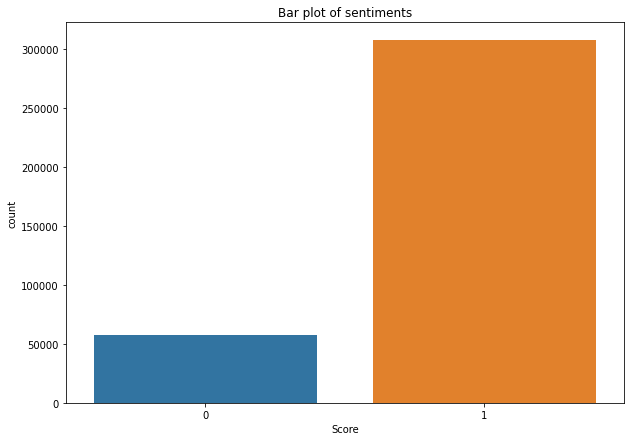

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(final_df['Score'])
plt.title("Bar plot of sentiments")

In [ ]:
# Text preprocessing
#Removing website links
# Removing html tags
# Decontracting(expanding from the original form)
# Removing the words with numeric digits
# Removing non-word characters
# Converting to lower case
# Removing stop words
# Performing Lemmatization

In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
#set of custom stop words
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
import nltk
nltk.download('wordnet')
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
final_df['Text'] = final_df['Text'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
final_df['Text'].head()

150523    witty little book make son laugh loud recite c...
150505    grow read sendak book watch really rosie movie...
150506    fun way children learn months year learn poems...
150507    great little book read aloud nice rhythm well ...
150508    book poetry months year go month cute little p...
Name: Text, dtype: object

In [ ]:
#Split data into 80:20 ratio
train_df, test_df = train_test_split(final_df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (291336, 10)
Test data size :  (72835, 10)


In [ ]:
#Model fitting
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           192032    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
3642/3642 [==============================] - 45s 11ms/step - loss: 0.2136 - accuracy: 0.9156 - val_loss: 0.1924 - val_accuracy: 0.9230
Epoch 2/3
3642/3642 [==============================] - 37s 10ms/step - loss: 0.1651 - accuracy: 0.9353 - val_loss: 0.1689 - val_accuracy: 0.9347
Epoch 3/3
3642/3642 [==============================] - 38s 11ms/step - loss: 0.1381 - accuracy: 0.9467 - val_loss: 0.1600 - val_accuracy: 0.9384


In [ ]:
# Evaluating model performance
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Score']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.9395208347635066
F1-score:  0.9644359402879034
Confusion matrix:


array([[ 8702,  2659],
       [ 1746, 59728]])